In [45]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

import pandas as pd

from IPython.display import Image

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

import warnings

In [46]:
%config InlineBackend.figure_format='retina'

In [47]:
force_cpu = True
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)

Using device cpu


In [48]:
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     root = '/content/drive/MyDrive/Colab Notebooks'
# except:
root = '.'

fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: ./backup
Figures folder: ./figures


# CartPole env

In [49]:
import gymnasium as gym
env = gym.make('CartPole-v1')

for _ in range(10):
    observation, info = env.reset(seed=0)
    # print(observation)
    t = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        action = env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        t += 1
        
env.close()

In [50]:
def eval_trajectory(env, trajectory):
    
    observation, info = env.reset(seed=0)
    t = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        try:
            action = trajectory[t]
            # action = env.action_space.sample()  # agent policy that uses the observation and info
            observation, reward, terminated, truncated, info = env.step(action)
            t += 1
        except IndexError:
            break
    return t


def eval_policy(env, policy, p=None, kl_div_factor=0.001, n_sample=10):
    
    q = dist.Binomial(probs=policy)
    trajectories = q.sample((n_sample, ))
    
    loss, p_sum = 0, 0

    for traj in trajectories:

        reward = eval_trajectory(trajectory=traj.long().cpu().numpy(), env=env)

        p_traj = q.log_prob(traj).sum().exp()
        loss -= p_traj * reward
        p_sum += p_traj

    loss /= p_sum
    
    if p is not None:
        kl_div = dist.kl_divergence(q, p).sum()
        loss += kl_div_factor * kl_div
    
    return loss/len(policy)

# Using reinforce

In [51]:
n_steps = 50
epochs = 500 

param = nn.Parameter(torch.zeros(n_steps))
optimizer = optim.Adam([param, ], lr=0.2)

n_sample = 10

p = dist.Binomial(probs=torch.ones(n_steps)*0.5)

with tqdm(total=epochs) as pbar:
    for epoch in range(1, epochs + 1):
        
        optimizer.zero_grad()
        
        loss = eval_policy(env=env, policy=torch.sigmoid(param), p=p)

        loss.backward()
        optimizer.step()

        pbar.update()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
n_sample = 1000
sum_reward = 0
with torch.no_grad():
    q = dist.Binomial(probs=torch.sigmoid(param))
    trajectories = q.sample((n_sample, ))
    for traj in trajectories:

        reward = eval_trajectory(trajectory=traj.long().numpy(), env=env)
        sum_reward += reward
print("After training", sum_reward/n_sample)

n_sample = 10000
sum_reward = 0
with torch.no_grad():
    q = dist.Binomial(probs=torch.sigmoid(torch.zeros(n_steps)))
    trajectories = q.sample((n_sample, ))
    for traj in trajectories:
        reward = eval_trajectory(trajectory=traj.long().numpy(), env=env)
        sum_reward += reward
print("Random", sum_reward/n_sample)

After training 44.055
Random 21.3506


In [12]:
with torch.no_grad():
    reward =  - eval_policy(env=env, policy=torch.sigmoid(param), n_sample=1000)
    print("After training", reward)
    reward = - eval_policy(env=env, policy=torch.sigmoid(torch.zeros(n_steps)), n_sample=1000)
    print("Random", reward)

After training tensor(0.9812)
Random tensor(0.4182)


# Tests

## Test regression network

In [13]:
size_z = 2

class Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(size_z, size_z*2)
        self.pred2 = nn.Linear(size_z*2, size_z)
        self.pred3 = nn.Linear(size_z, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x).squeeze()     
        return x

def regression_loss(pred, y):
    loss = nn.MSELoss(reduction="mean")
    return loss(pred, y)

reg = Regression()
reg.to(device)
reg.train()

epochs= 5000
n = 2000

torch.manual_seed(123)
x = torch.randn((n, size_z))
# x = torch.randn((n, size_z-1))
# x = torch.hstack([x, torch.ones((n, 1))])

y = (2129393 + 2.423*x - 3.3*x**2).sum(dim=1)
y = (y - y.mean()) / y.std()

x = x.to(device)
y = y.to(device)

optimizer = optim.Adam(reg.parameters(), lr=0.1)

with tqdm(total=epochs) as pbar:
    
    for epoch in range(epochs):
      
        optimizer.zero_grad()
      
        pred = reg(x)
        loss = regression_loss(y=y, pred=pred)
      
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
          pbar.update(1000)
          pbar.set_postfix(loss=f"{loss.item():.4f}")
        

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
x = torch.randn((3, 2))

print(torch.hstack([x, torch.ones((3, 1))]))

tensor([[-1.1157,  1.8411,  1.0000],
        [ 0.5819,  0.9691,  1.0000],
        [-1.8388,  0.8474,  1.0000]])


In [15]:
print(x.mean(), x.std(), x.min(), x.max())
print(y.mean(), y.std(), y.min(), y.max())

tensor(0.2142) tensor(1.3955) tensor(-1.8388) tensor(1.8411)
tensor(0.0454) tensor(0.9990) tensor(-7.1267) tensor(1.0558)


## Test policy gradient

In [16]:
class DecisionMaker(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.param = nn.Parameter(torch.zeros(size_z))


size_z = n_steps
dm = DecisionMaker(size_z).to(device)
with torch.no_grad():
    z = dm.param
    x = torch.sigmoid(z)
    y = eval_policy(env=env, policy=x).to(device)
print(f"Eval start: {y.item():.4f}")

learning_rate = 0.2

n_epoch = 500

p = dist.Binomial(probs=torch.ones(n_steps).to(device)*0.5)
optimizer = optim.Adam(dm.parameters(), lr=learning_rate)

state_dict = None

hist_y = []

with tqdm(total=n_epoch) as pbar:
    for _ in range(n_epoch):

        optimizer.zero_grad()
        
        z = dm.param
        x = torch.sigmoid(z)
        loss = eval_policy(env=env, policy=x, p=p).to(device)
        y = - loss
        
        loss.backward()
        optimizer.step()

        hist_y.append(y.detach().item())
        best_value = np.max(hist_y) 
        
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.4f}", best=f"{best_value:.4f}")

Eval start: -0.2660


  0%|          | 0/500 [00:00<?, ?it/s]

## Test VAE

### Creating a dataset

In [17]:
class TrainDataset(Dataset): 
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        super().__init__()
    def __len__(self):
        return len(self.train_y)
    def __getitem__(self, idx):
        return self.train_x[idx], self.train_y[idx]

In [18]:
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(1234)

n_sample_start = 2000
n_steps = 50

print("creating samples")
train_x = torch.rand(n_sample_start, n_steps).to(device)

with torch.no_grad():
    train_y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in train_x]).to(device)

train_dataset = TrainDataset(train_x=train_x, train_y=train_y)

creating samples


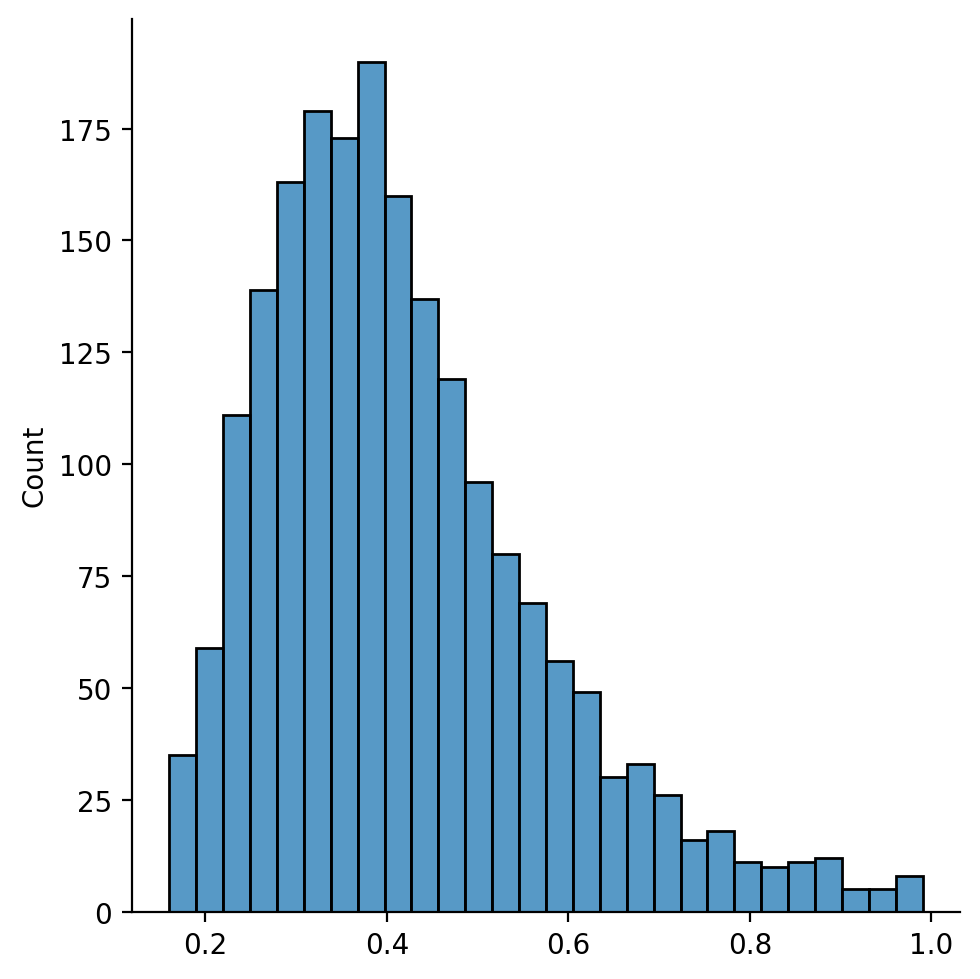

In [19]:
sns.displot(train_dataset.train_y)

### Defining VAE model

In [20]:
class VAE(nn.Module):
    def __init__(self, n_steps, size_z):
        super().__init__()

        self.enc1 = nn.Linear(n_steps, 40)
        self.enc2 = nn.Linear(40, 20)
        self.mu = nn.Linear(20, size_z)
        self.logvar = nn.Linear(20, size_z)
        
        self.dec1 = nn.Linear(size_z, 20)
        self.dec2 = nn.Linear(20, 40)
        self.dec3 = nn.Linear(40, n_steps)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.dec1(z))
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred1 = nn.Linear(size_z, size_z*2)
        self.pred2 = nn.Linear(size_z*2, size_z)
        self.pred3 = nn.Linear(size_z, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = torch.sigmoid(self.pred3(x).squeeze())     
        return x

### Training VAE

In [21]:


size_z = 2

vae = VAE(n_steps=n_steps, size_z=size_z).to(device)
reg = Regression(size_z).to(device)

vae_learning_rate = 0.001

n_epoch_vae = 1000
batch_size_vae = 200
weight_reg_loss = 10e3 #10000  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_vae)

optimizer_vae = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=vae_learning_rate)

with tqdm(total=n_epoch_vae, leave=True) as pbar_vae:
    
    for epoch in range(n_epoch_vae):
        
        train_vae_loss, train_reg_loss = 0, 0
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            # see Appendix B from VAE paper:
            # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
            # https://arxiv.org/abs/1312.6114
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
            l_vae = bce + kl

            pred = reg(mu)
            l_reg = weight_reg_loss*nn.MSELoss(reduction="sum")(target=y, input=pred)

            loss = l_vae + l_reg
            
            loss.backward()
            optimizer_vae.step()

            train_vae_loss += l_vae.item()
            train_reg_loss += l_reg.item()

        pbar_vae.update()
        pbar_vae.set_postfix({
            "loss VAE": f"{train_vae_loss/len(train_y):.4f}",
            "loss regression": f"{train_reg_loss/len(train_y):.4f}"
        })


  0%|          | 0/1000 [00:00<?, ?it/s]

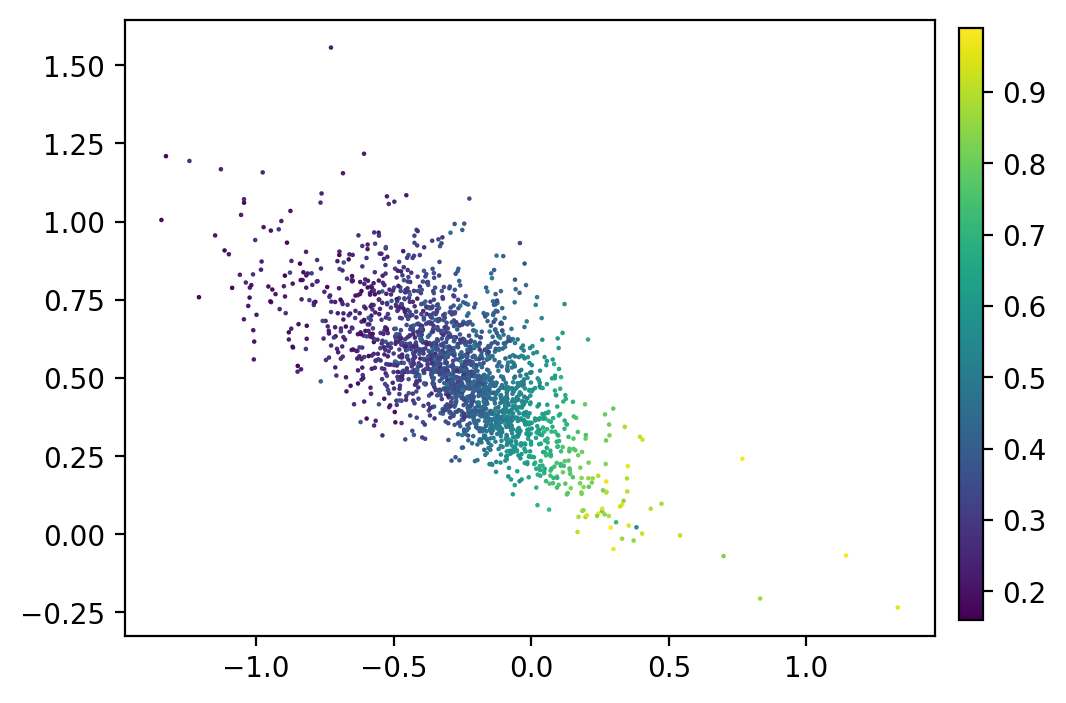

In [22]:
vae.eval()
x, y = train_dataset.train_x, train_dataset.train_y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [26]:
vae.eval()
rx, ry = np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in x])  

    x = x.cpu().numpy()
    y = y.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

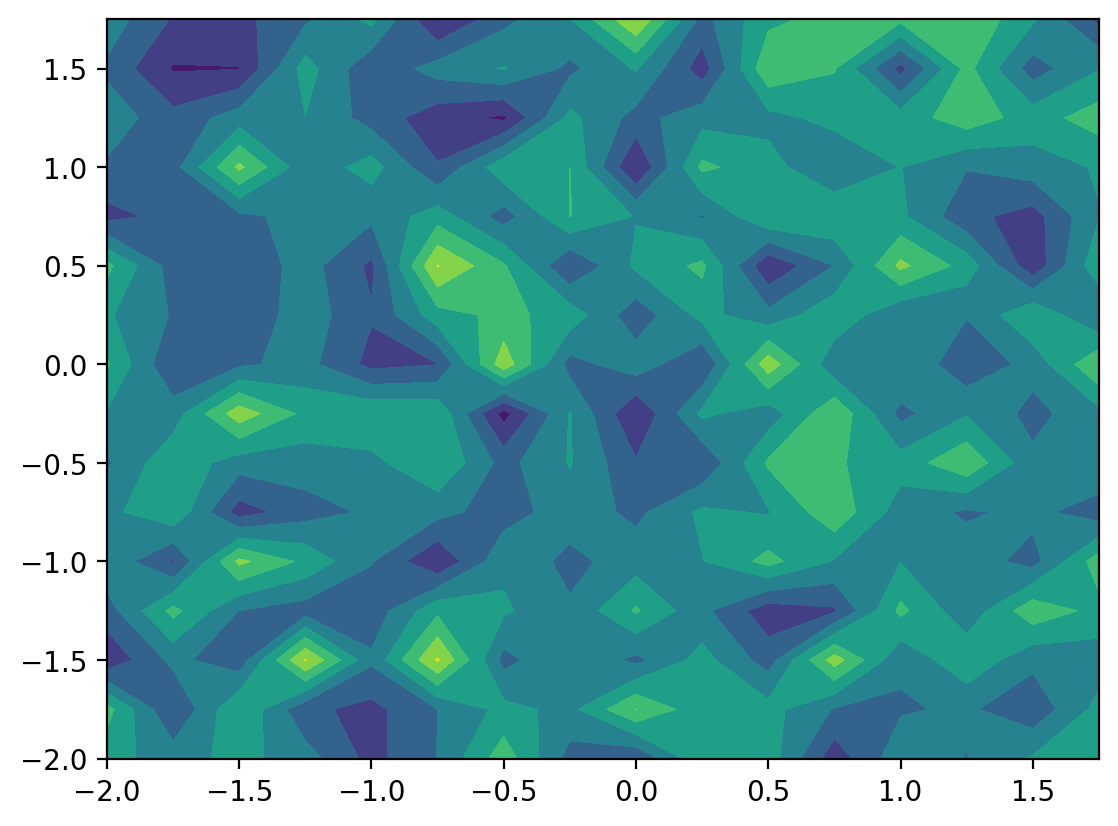

In [27]:
im = plt.contourf(gx, gy, gz, cmap='viridis')

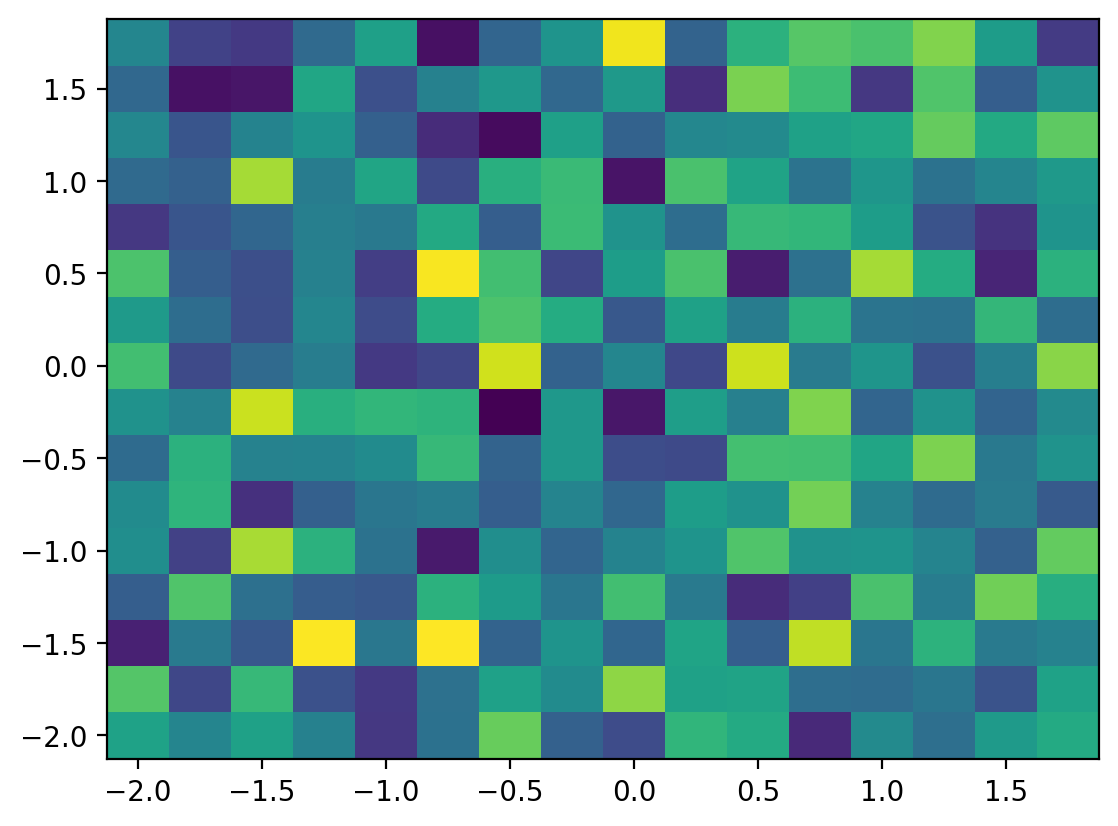

In [28]:
plt.pcolormesh(gx, gy, gz);

# Using GP after VAE trained

In [37]:
# Remove warnings
warnings.filterwarnings("ignore")

dtype=torch.float

acq_opt__batch_size = 3
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 13537

n_batch = 10

n_sample_start = 10


best_observed = []
cand_observed = []
val_observed = []

# Create a small dataset from the dataset the VAE has been trained with
best = torch.topk(train_dataset.train_y, k=n_sample_start).indices
train_x = train_dataset.train_x[best]
train_y = train_dataset.train_y[best]
with torch.no_grad():
    vae.eval()
    train_z, _ = vae.encode(train_dataset.train_x[best])

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # fit the GP model
        # normalize(train_h, bounds=bounds), 
        # standardize(train_obj) 
        model = SingleTaskGP(train_X=train_z, train_Y=train_y.unsqueeze(dim=1))
        # if state_dict is not None:
        #     model.load_state_dict(state_dict)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        mll.to(device)
        fit_gpytorch_mll(mll)

        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(
            sample_shape=qmc_sampler__sample_shape,
            seed=qmc_sampler__seed
        )
        qEI = qExpectedImprovement(
            model=model, 
            sampler=qmc_sampler, 
            best_f=train_y.max())

        # optimize and get new observation
        # optimize
        bounds = torch.zeros((2, size_z))
        bounds[0, :] = - 4
        bounds[1, :] = 4
        candidates, _ = optimize_acqf(
            acq_function=qEI,
            bounds=bounds,
            q=acq_opt__batch_size,
            num_restarts=acq_opt__num_restarts,
            raw_samples=acq_opt__raw_samples,
        )

        # observe new values 
        with torch.no_grad():
            new_z = candidates.detach()
            new_x = vae.decode(new_z)
            new_y = torch.tensor([
                - eval_policy(
                    env=env,
                    policy=pol) for pol in new_x])  

        # update training points
        train_z = torch.cat((train_z, new_z))
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)
        cand_observed.append([cand.numpy().tolist() for cand in candidates])
        val_observed.append([val.item() for val in new_y])

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix({"best": f"{best_value:.2f}"})

  0%|          | 0/10 [00:00<?, ?it/s]

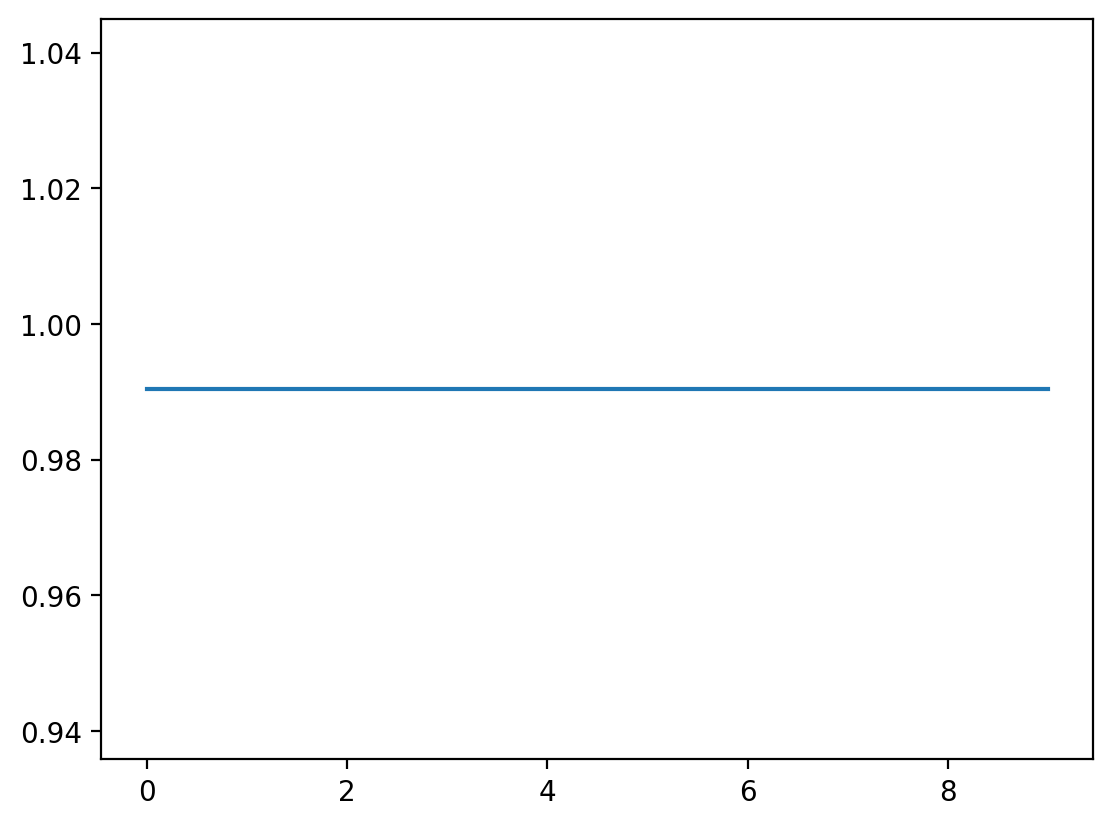

In [38]:
fig, ax = plt.subplots()
ax.plot(best_observed);

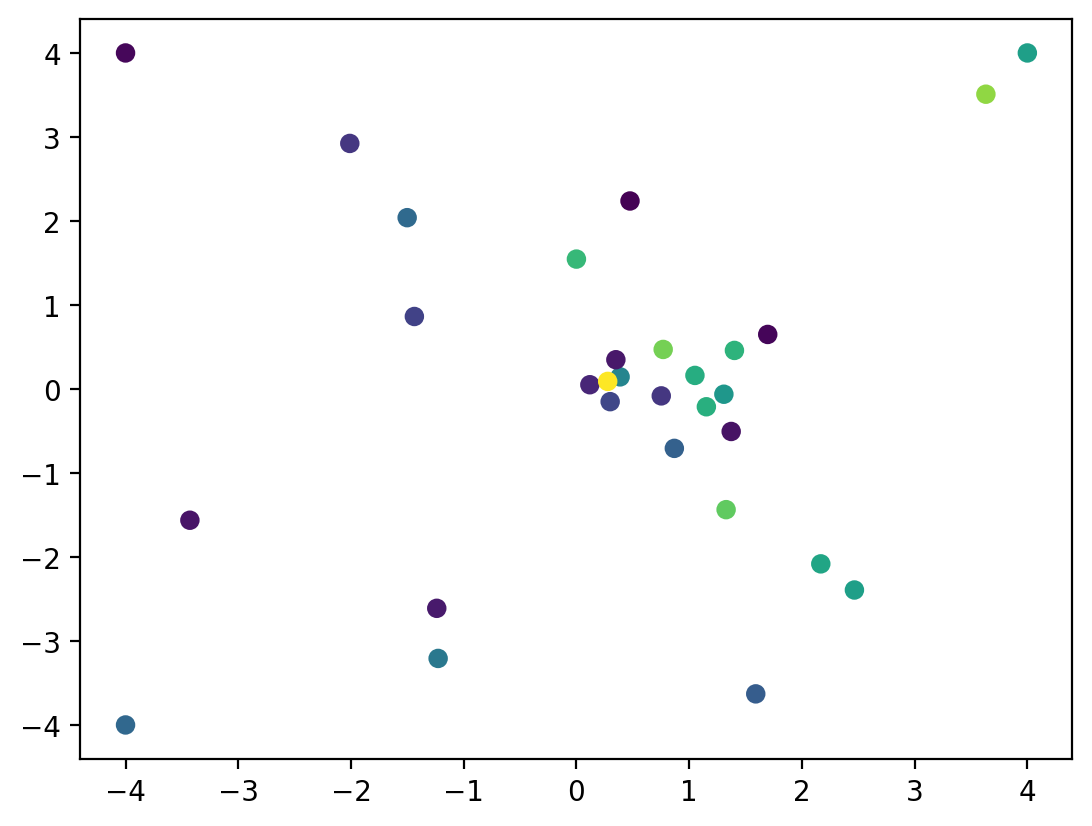

In [39]:
cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed)
plt.scatter(x=cand_observed[:, :, 0], y=cand_observed[:, :, 1], c=val_observed,  cmap="viridis");

In [41]:
val_observed.max()

0.6492233872413635

## Same thing but with NN

Not working at the moment (and probably never will hem hem)

In [44]:
class DecisionMaker(nn.Module):
    def __init__(self, init_value):
        super().__init__()
        self.param = nn.Parameter(init_value)


dm_init_value, _ = vae.encode(train_dataset.train_x[torch.argmax(train_dataset.train_y)])

dm = DecisionMaker(init_value=dm_init_value)
dm.to(device)
dm.train()

hist_y = []

epochs= 5000

optimizer = optim.Adam(dm.parameters(), lr=0.01)

with tqdm(total=epochs) as pbar:
    
    for epoch in range(epochs):
      
        optimizer.zero_grad()
        
        z = dm.param
        x = vae.decode(z)
        loss = eval_policy(env=env, policy=x, p=None).to(device)
        y = - loss
        
        loss.backward()
        optimizer.step()

        hist_y.append(y.detach().item())
        best_value = np.max(hist_y) 
        
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.4f}", best=f"{best_value:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]